# Data Quality Checks 

This document outlines PySpark scripts for data quality checks in `yelp_analytics`. The checks include:
- **Null/Empty Value Checks**: Ensure key columns are not NULL or empty.
- **Foreign Key Checks**: Verify referential integrity between fact and dimension tables.
- **Logging**: Store results in `config_db.data_quality_log`.


## Logging Function

```python

def log_dq_result(dq_log_id, table_name, quality_check, description, total_rows, passed_rows, failed_rows, execution_time_seconds=0.0, error_message=None):
    error_message = error_message or ""
    status = "SUCCESS" if failed_rows == 0 else "FAILURE"
    log_df = spark.createDataFrame([(dq_log_id, table_name, quality_check, description, total_rows, passed_rows, failed_rows, datetime.now(), execution_time_seconds, status, error_message)], schema=log_schema)
    log_df.write.format("delta").mode("append").saveAsTable("config_db.data_quality_log")
```

## Data Quality Checks

### Null Checks

```python
def null_check(table_name, key_columns, dq_log_id, description):
    df = spark.table(table_name)
    total_rows = df.count()
    failed_rows = df.filter((col(key_columns[0]).isNull()) | (trim(col(key_columns[0])) == "")).count()
    log_dq_result(dq_log_id, table_name, "null_check", description, total_rows, total_rows - failed_rows, failed_rows)
```

### Foreign Key Checks

```python
def foreign_key_check(fact_table, fact_column, parent_table, parent_column, dq_log_id, description):
    fact_df, parent_keys = spark.table(fact_table), spark.table(parent_table).select(parent_column).distinct()
    total_rows, failed_rows = fact_df.count(), fact_df.join(parent_keys, fact_df[fact_column] == parent_keys[parent_column], "left_anti").count()
    log_dq_result(dq_log_id, fact_table, "fk_check", description, total_rows, total_rows - failed_rows, failed_rows)
```

## Run Checks

```python
null_check("yelp_analytics.dim_business", ["business_id"], 101, "Check null business_id")
foreign_key_check("yelp_analytics.fact_review", "business_id", "yelp_analytics.dim_business", "business_id", 201, "Verify business_id in dim_business")
```


In [0]:
from pyspark.sql.functions import col, trim
from pyspark.sql import SparkSession
from datetime import datetime
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, DoubleType

spark = SparkSession.builder.getOrCreate()

# Define an explicit schema matching your config_db.data_quality_log table
log_schema = StructType([
    StructField("dq_log_id", IntegerType(), True),
    StructField("table_name", StringType(), True),
    StructField("quality_check", StringType(), True),
    StructField("description", StringType(), True),
    StructField("total_rows", IntegerType(), True),
    StructField("passed_rows", IntegerType(), True),
    StructField("failed_rows", IntegerType(), True),
    StructField("check_time", TimestampType(), True),
    StructField("execution_time_seconds", DoubleType(), True),
    StructField("status", StringType(), True),
    StructField("error_message", StringType(), True)
])

def log_dq_result(dq_log_id, table_name, quality_check, description, total_rows, passed_rows, failed_rows, execution_time_seconds=0.0, error_message=None):
    """
    Create a single-row DataFrame with the quality check results and append it to the data_quality_log table.
    """
    # Ensure error_message is a string (not None) so Spark can infer its type correctly.
    error_message = error_message if error_message is not None else ""
    status = "SUCCESS" if failed_rows == 0 else "FAILURE"
    current_time = datetime.now()  # Use Python's datetime for a literal timestamp
    dq_data = [(dq_log_id, table_name, quality_check, description, total_rows, passed_rows, failed_rows,
                current_time, execution_time_seconds, status, error_message)]
    
    # Create the DataFrame using the explicit schema
    log_df = spark.createDataFrame(dq_data, schema=log_schema)
    
    # Append the log row to the Delta table in config_db
    log_df.write.format("delta").mode("append").saveAsTable("config_db.data_quality_log")
    

def null_check(table_name, key_columns, dq_log_id, description):
    """
    Check that one or more key columns in the table are not NULL or empty.
    """
    df = spark.table(table_name)
    total_rows = df.count()
    
    # Build a condition to flag rows with null or empty values in any key column.
    condition = None
    for key in key_columns:
        curr_cond = (col(key).isNull()) | (trim(col(key)) == "")
        condition = curr_cond if condition is None else condition | curr_cond

    failed_rows = df.filter(condition).count()
    passed_rows = total_rows - failed_rows

    log_dq_result(dq_log_id, table_name, "null_check", description, total_rows, passed_rows, failed_rows)


def foreign_key_check(fact_table, fact_column, parent_table, parent_column, dq_log_id, description):
    """
    Check that each value in fact_table[fact_column] exists in parent_table[parent_column].
    """
    fact_df = spark.table(fact_table)
    total_rows = fact_df.count()

    # Get distinct keys from the parent table.
    parent_keys = spark.table(parent_table).select(parent_column).distinct()

    # Identify rows in fact_df that do NOT have a matching key in the parent table.
    failed_df = fact_df.join(parent_keys, fact_df[fact_column] == parent_keys[parent_column], "left_anti")
    failed_rows = failed_df.count()
    passed_rows = total_rows - failed_rows

    log_dq_result(dq_log_id, fact_table, "fk_check_" + fact_column, description, total_rows, passed_rows, failed_rows)


# ======================================================
# 1. Null/Empty Value Checks
# ======================================================

null_check("yelp_analytics.dim_business", ["business_id"], 101, "Check for null or empty business_id in dim_business")
null_check("yelp_analytics.dim_user", ["user_id"], 102, "Check for null or empty user_id in dim_user")
null_check("yelp_analytics.fact_review", ["review_id"], 103, "Check for null or empty review_id in fact_review")
null_check("yelp_analytics.fact_checkin", ["business_id"], 104, "Check for null or empty business_id in fact_checkin")
null_check("yelp_analytics.fact_tip", ["business_id", "user_id"], 105, "Check for null or empty business_id or user_id in fact_tip")
null_check("yelp_analytics.dim_date", ["full_date"], 106, "Check for null full_date in dim_date")
null_check("yelp_analytics.datamart_rising_star_businesses", ["business_id"], 107, "Check for null or empty business_id in datamart_rising_star_businesses")


# ======================================================
# 2. Foreign Key Checks
# ======================================================

# fact_review: Check that business_id exists in dim_business
foreign_key_check("yelp_analytics.fact_review", "business_id", "yelp_analytics.dim_business", "business_id", 201,
                    "Check that business_id in fact_review exists in dim_business")

# fact_review: Check that user_id exists in dim_user
foreign_key_check("yelp_analytics.fact_review", "user_id", "yelp_analytics.dim_user", "user_id", 202,
                    "Check that user_id in fact_review exists in dim_user")

# fact_tip: Check that business_id exists in dim_business
foreign_key_check("yelp_analytics.fact_tip", "business_id", "yelp_analytics.dim_business", "business_id", 203,
                    "Check that business_id in fact_tip exists in dim_business")

# fact_tip: Check that user_id exists in dim_user
foreign_key_check("yelp_analytics.fact_tip", "user_id", "yelp_analytics.dim_user", "user_id", 204,
                    "Check that user_id in fact_tip exists in dim_user")

# fact_checkin: Check that business_id exists in dim_business
foreign_key_check("yelp_analytics.fact_checkin", "business_id", "yelp_analytics.dim_business", "business_id", 205,
                    "Check that business_id in fact_checkin exists in dim_business")

# datamart_rising_star_businesses: Check that business_id exists in dim_business
foreign_key_check("yelp_analytics.datamart_rising_star_businesses", "business_id", "yelp_analytics.dim_business", "business_id", 206,
                    "Check that business_id in datamart_rising_star_businesses exists in dim_business")


Data Quality Log:
<Figure size 864x432 with 0 Axes>

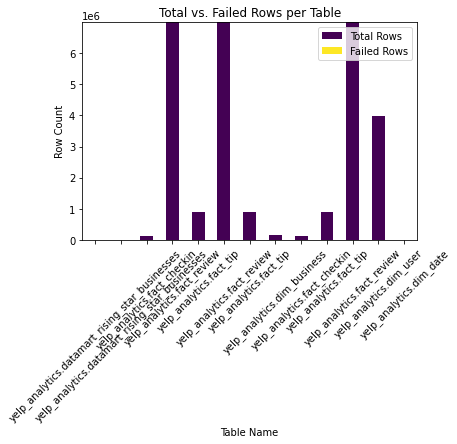

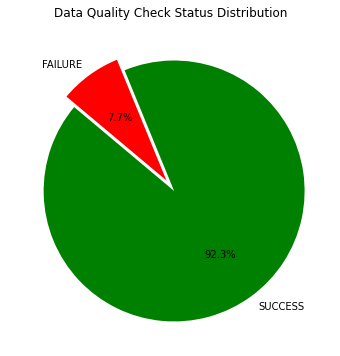

In [0]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("DataQualityVisualization").getOrCreate()

# Query the data_quality_log table
df_spark = spark.sql("SELECT * FROM config_db.data_quality_log")

# Convert to Pandas for visualization
df = df_spark.toPandas()

# Display the DataFrame
print("Data Quality Log:")

# Visualization 1: Bar chart - Total rows vs. Failed rows per table
plt.figure(figsize=(12, 6))
df.set_index("table_name")[["total_rows", "failed_rows"]].plot(kind="bar", stacked=True, colormap="viridis")
plt.title("Total vs. Failed Rows per Table")
plt.xlabel("Table Name")
plt.ylabel("Row Count")
plt.xticks(rotation=45)
plt.legend(["Total Rows", "Failed Rows"])
plt.show()

# Visualization 2: Pie chart - Success vs. Failure distribution
plt.figure(figsize=(6, 6))
df["status"].value_counts().plot.pie(autopct="%1.1f%%", colors=["green", "red"], startangle=140, explode=[0.05, 0.05])
plt.title("Data Quality Check Status Distribution")
plt.ylabel("")
plt.show()


